<img width="800px" src="../images/img/001.png"></img>
# NOM DU PROJET: **Application mobile d'aide à la conduite  de reconnaissance des panneau de circulation routiere**
# <!-- TITLE --> Etape2- premier modele de convolution 
<!--Auteur : Tchotaneu Ngatcha Giresse (INSTITUTE FRANCOPHONE INTERNATIONAL) -->

lien de telechargement : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

##  Ce que nous allons realiser:

 - lire les differents dataset que nous avons ameliorer 
 - Contruire notre model
 - Entrainer notre model
 - Evaluer notre model



 ## 1: preparation de l'environement de travail (importation des bibiotheque utiles )

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os,time,sys

from importlib import reload

sys.path.append('..')
import mesFonctionsPersonnelles.fonctionDeBase as projet

run_dir = './run/GTSRB2.001'
datasets_dir = projet.init('GTSRB2', run_dir)

<br>**Projet de reconnaissance de forme**

Version              : 2.0.35
Notebook id          : GTSRB2
Run time             : Wednesday 26 October 2022, 14:35:48
Hostname             : DESKTOP-36O6V1H (Windows)
Tensorflow log level : Info + Warning + Error  (=0)
Datasets dir         : C:\Users\TCHOTANEU\LesProjetsGiresse\datasets
Run dir              : ./run/GTSRB2.001
Update keras cache   : False
tensorflow           : 2.9.1
tensorflow.keras     : 2.9.0
numpy                : 1.23.2
sklearn              : 1.1.2
matplotlib           : 3.5.3
pandas               : 1.4.3


## 2 - Definition de quelques parametres

In [2]:
enhanced_dir = './data'
dataset_name  = 'set-24x24-L'
batch_size    = 64
epochs        = 10
scale    = 1
fit_verbosity = 1

In [4]:
projet.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale ', 'fit_verbosity')

## 2 - chargement du dataset 

In [8]:
def read_dataset(enhanced_dir, dataset_name):

    # ---- lire le dataset
    projet.chrono_start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    # ---- melange
    x_train,y_train=projet.shuffle_np_dataset(x_train,y_train)

    
    duration = projet.chrono_stop(hdelay=True)
    size     =projet.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" est chargé et melangé en. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---lire le dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- 
#
x_train,y_train, x_test,y_test = projet.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(39209, 24, 24, 1) (39209,)
Dataset "set-24x24-L" est chargé et melangé en. (228.6 Mo in 00:00:00 174ms)


## 3 - Consultez l'ensemble des données


x_train :  (39209, 24, 24, 1)
y_train :  (39209,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


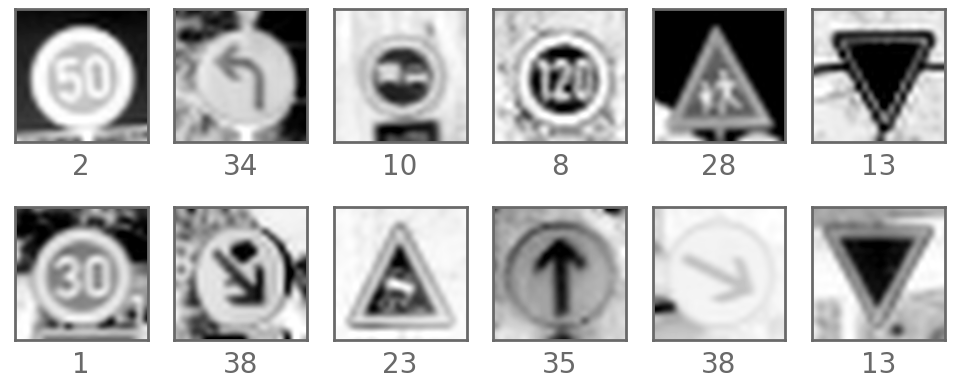

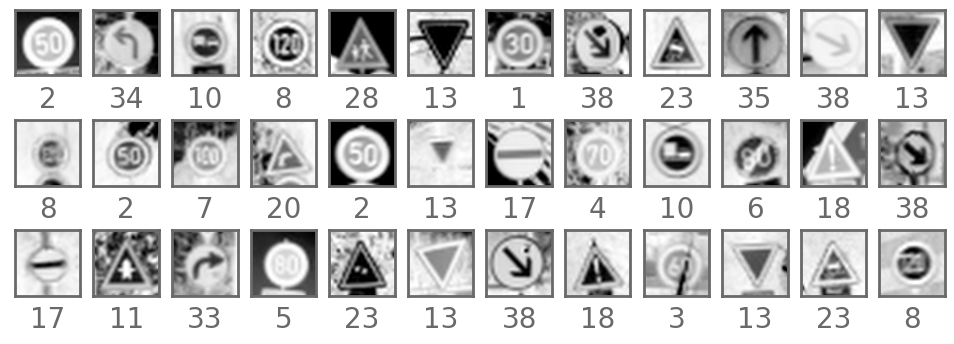

In [10]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

projet.plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2, save_as='01-dataset-medium')
projet.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='02-dataset-small')

##  4 - Creation du  model


In [11]:

# modele Simple
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model
    
# model un peu complexe

def get_model_v2(lx,ly,lz):
    model = keras.models.Sequential()

    model.add( keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(lx,ly,lz), activation='relu'))
    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten())
    model.add( keras.layers.Dense(512, activation='relu'))
    model.add( keras.layers.Dropout(0.5))
    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

# un autre model moins complexe que le deuxieme 
#
def get_model_v3(lx,ly,lz):
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## 5 - entrainement du model 
**La forme de mes données**

In [12]:
(n,lx,ly,lz) = x_train.shape
print("Les images de l'ensemble de données ont la forme suivante : ",(lx,ly,lz))

Les images de l'ensemble de données ont la forme suivante :  (24, 24, 1)


**Obtenir et compiler un modèle, avec la forme des données**

In [13]:
model = get_model_v1(lx,ly,lz)

model.summary()

model.compile(optimizer = 'adam',
              loss      = 'sparse_categorical_crossentropy',
              metrics   = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 96)        960       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 192)         166080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 192)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 192)         0

**entrainement  :**

In [15]:
projet.chrono_start()

# ---- melange des donnees 
x_train,y_train=projet.shuffle_np_dataset(x_train,y_train)

# ---- entrainement 
history = model.fit(  x_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = fit_verbosity,
                      validation_data = (x_test, y_test))

projet.chrono_show()

Epoch 1/10
613/613 [==============================] - 61s 98ms/step - loss: 1.1948 - accuracy: 0.6710 - val_loss: 0.4192 - val_accuracy: 0.9010
Epoch 2/10
613/613 [==============================] - 64s 105ms/step - loss: 0.2118 - accuracy: 0.9401 - val_loss: 0.3207 - val_accuracy: 0.9236
Epoch 3/10
613/613 [==============================] - 63s 103ms/step - loss: 0.1202 - accuracy: 0.9648 - val_loss: 0.2650 - val_accuracy: 0.9371
Epoch 4/10
613/613 [==============================] - 62s 102ms/step - loss: 0.0837 - accuracy: 0.9755 - val_loss: 0.2452 - val_accuracy: 0.9380
Epoch 5/10
613/613 [==============================] - 62s 102ms/step - loss: 0.0609 - accuracy: 0.9817 - val_loss: 0.2462 - val_accuracy: 0.9418
Epoch 6/10
613/613 [==============================] - 62s 101ms/step - loss: 0.0521 - accuracy: 0.9842 - val_loss: 0.2606 - val_accuracy: 0.9443
Epoch 7/10
613/613 [==============================] - 69s 112ms/step - loss: 0.0438 - accuracy: 0.9866 - val_loss: 0.2298 - val_acc

## 5 - Evaluation 

In [16]:
max_val_accuracy = max(history.history["val_accuracy"])
print("La précision maximale de la validation est : {:.4f}".format(max_val_accuracy))

La précision maximale de la validation est : 0.9518


In [17]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Perte de test     : {:5.4f}'.format(score[0]))
print('Précision du test  : {:5.4f}'.format(score[1]))

Perte de test     : 0.2367
Précision du test  : 0.9518


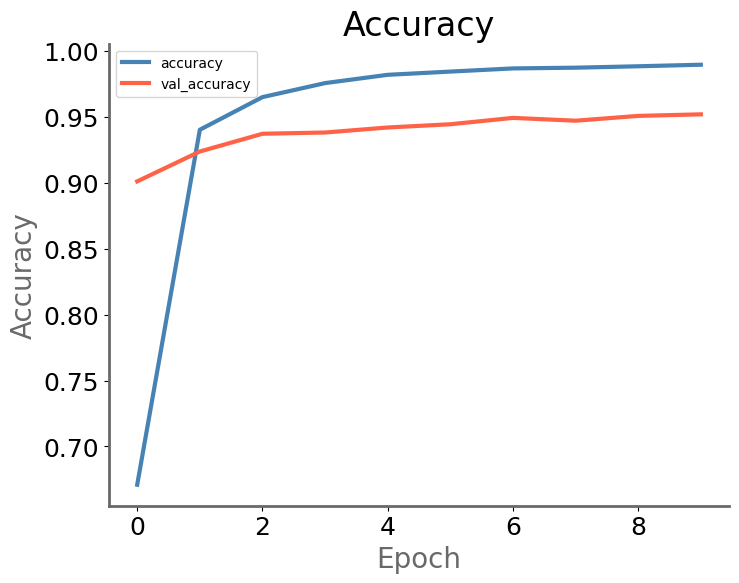

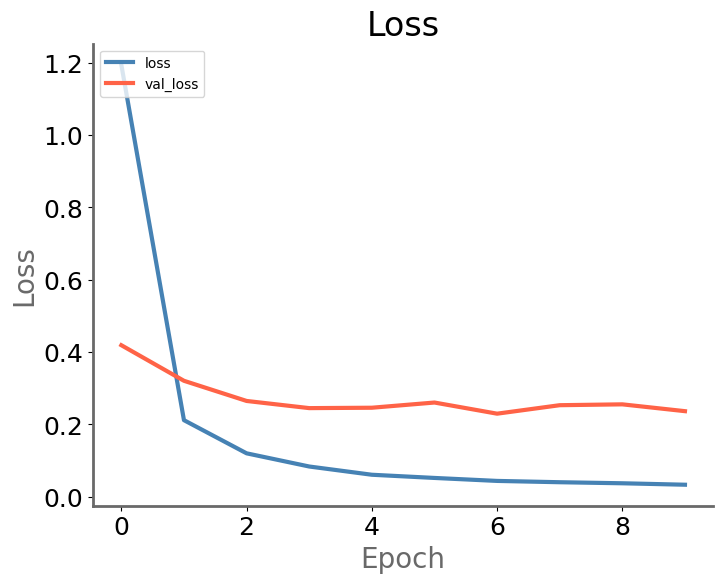

In [21]:
projet.plot_history(history, save_as='02-history')

In [18]:
projet.end()

**Fin du traitement :** Wednesday 26 October 2022, 13:08:35  
**Durée :** 00:21:17 944ms  
Notre notebook se termine ici ,le code est disponible sur  :-)  
[https://github.com/tchotaneu](https://github.com/tchotaneu)